As we've seen in my [previous post on rice cooker temperature measurements](http://flothesof.github.io/rice-cooker-temperature.html), sometimes it's easier to perform an experiment than to explain it, as the post ended on many open questions. In this post, I'll propose a simple model of what's going on during the cooking process that I measured previously.

# Recap about what's happening in the rice cooker 

Essentially, the rice cooker does what other cooking instruments in your kitchen do: it uses electric energy and converts it to heat to break molecular links in food, making it easier to digest for humans. This is what's called cooking. 

When we look into the details of this heat transfer to food, this is what seems to happen: an electric heater transfers heat to the metal pot. The pot transfers the heat to the water. The water transfers the heat to the rice, which gets cooked. While transfering heat to the rice, water boils and evaporates. Once it has evaporated entirely, the cooking is finished and the rice cooker turns itself off.

As you've surely noticed, the previous paragraph is full of references to heat. The model we will propose below will thus center around the heat balance of our system.

# Heat balance for the rice cooker 

Let's denote by $Q_h$ the heat produced by the thermal heater of the rice cooker. Assuming it has the fixed power of 500 W as described on the seller's website, the quantity of heat generated after a time $t$ is written as:

$$
Q_h = P \Delta t
$$

Here, $P$ are the 500 W from the thermal resistance.

We'll assume that the metal pot instantly transfers the heat to the water. Thus the heat absorbed by the water will elevate its temperature. We will assume that the temperature is uniform in the water. Thus the temperature, while the water is not boiling, is written as:

$$
T_w = T_0 + Q_h / c_p / m
$$

Above, we've made use of the [specific heat capacity](https://en.wikipedia.org/wiki/Heat_capacity) of water, which we will assume to be $c_p = 4.2 \, kJ/(kg⋅K)$. This means that if we want to raise the temperature of a kilogram of water by 1 degree, we need to transfer it 4200 joules.

When the water reaches 100°C at atmospheric pressure, it begins to boil. The boiling process is an indication of the transformation that is taking place: water turns from a liquid to a gas. This process costs a lot more energy than the heating process. We'll assume [vaporization](https://en.wikipedia.org/wiki/Enthalpy_of_vaporization) to take $\Delta H _{vap} = 2257 \, kJ / kg$. 

Once it becomes gas, the water mixes with the air in the rice cooker atmosphere. At the same time, a flux of outgoing hot air and water gas appears. This is where our measurement is carried out. In a first step, we'll simplify our problem and just assume we measure the temperature of the water.

Let's now turn to some numerical computation based on these numbers.

# Numerical solution 

We'll try to compute the solution of the previous problem description using simple time stepping. At each time step, we can compute the heat produced by the heater, the remaining mass of water and the temperature of the water (and thus the temperature of the air, which is our measured value).

In [9]:
def solve(t, P, m_0, T_0):
    "Returns the heat produced, remaining water mass and water temperature at time t (in seconds)."
    CP = 4.2e3
    DeltaHV = 2257e3
    Q_h = P * t
    T = T_0 + Q_h / CP / m_0
    if T >= 100:
        delta_Q = Q_h - (100 - T_0) * CP * m_0
        T = 100
    else:
        delta_Q = 0
    m = m_0 - delta_Q / DeltaHV
    if m < 0:
        m = 0
    return Q_h, m, T

I've introduced all of the starting parameters to our solving function. Let's now evaluate it at different times:

In [10]:
for t in [0, 2*60, 10*60, 30*60, 60*60]:
    print("time {} s: Q_h={:.2f} J, m={:.2} kg, T={:.2f} °C".format(t, *solve(t, 500, 1, 20)))

time 0 s: Q_h=0.00 J, m=1.0 kg, T=20.00 °C
time 120 s: Q_h=60000.00 J, m=1.0 kg, T=34.29 °C
time 600 s: Q_h=300000.00 J, m=1.0 kg, T=91.43 °C
time 1800 s: Q_h=900000.00 J, m=0.75 kg, T=100.00 °C
time 3600 s: Q_h=1800000.00 J, m=0.35 kg, T=100.00 °C


We can plot this:

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

In [36]:
data = np.array([(t,) + solve(t, 500, 0.5, 20) for t in np.arange(35 * 60)])

(-0.05, 0.55)

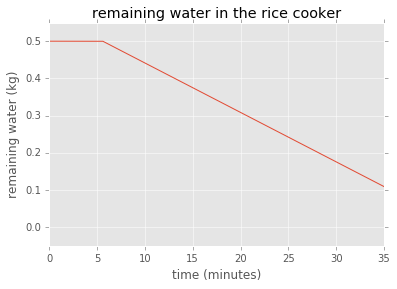

In [37]:
plt.plot(data[:, 0]/60, data[:, 2])
plt.xlabel('time (minutes)')
plt.ylabel('remaining water (kg)')
plt.title('remaining water in the rice cooker')
plt.ylim(-0.05, 0.55)

We can also plot the temperature above the rice cooker as a function of time:

(15, 115)

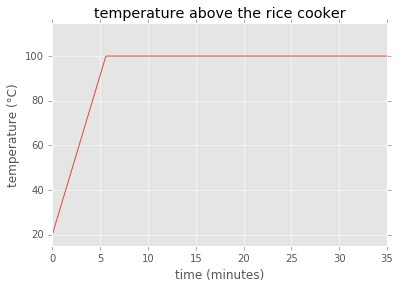

In [38]:
plt.plot(data[:, 0]/60, data[:, 3])
plt.xlabel('time (minutes)')
plt.ylabel('temperature (°C)')
plt.title('temperature above the rice cooker')
plt.ylim(15, 115)

Let's now compare this simple model to our previous measurement.

# Comparison with experiment 

In [39]:
import pandas as pd
df = pd.read_csv('log_20160327_v2.txt', parse_dates=['time'])
ind = df.pop('time')
df = df.set_index((ind - ind.values[0]).astype('timedelta64[s]') / 60.)

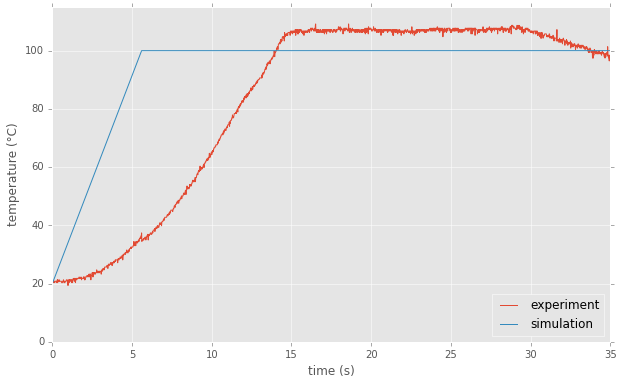

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df.index.values, df.temperature.values, label='experiment')
plt.plot(data[:, 0]/60, data[:, 3], label='simulation')
plt.xlim(0, 35)
plt.ylim(0, 115)
plt.legend(loc='lower right')
plt.ylabel('temperature (°C)')
plt.xlabel('time (s)')

This graph allows us to pinpoint a lot of things.

First, we see that our model has the same shape but does not yield good predictions. For instance:

- the initial temperature increase is not well matched: experiment goes up smoothly while our model assumes we heat the bulk of the water instantly
- our model underestimates the time to reach the maximum temperature
- our model undersestimates the maximum temperature: we assume the air water-gas mixture reaches 100°C, while it seems it reaches slightly higher temperatures
- our model doesn't allow for cooling of the rice cooker once the cooking is finished
- our model also doesn't predict the right cooking stopping time (checking the previous plot above, we see that the rice cooker stops earlier than our model, which hasn't yet reached an empty water state)

# Conclusions 

The model described in this blog post is really simple. Although it allows to qualitatively understand the heating process, which is basically just making water boil, it's pretty bad at enabling finer understanding of the cooking process. Improvements that would be needed to make it more accurate (in my opinion, but I'm no expert) would be:

- take into account layers of water: could allow the replication of the inital slope in the temperature
- investigate water air mixture: explain the final temperature constantly higher than 100°C (due to a balance between hot air and hot water gas?)
- take into account thermal losses, which explain the decrease of the temperature after t=30 minutes
- take into account the rice itself, which is heated and cooked in the process
